In [37]:
import xgboost as xgb
import pandas as pd
import numpy as np
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from scipy.sparse import csr_matrix


features = pd.read_csv('train/aidata_54k.csv', header=0, sep=',', dtype = {'segments': np.str})

#features = pd.read_csv('train/aidata.csv', header = 0, dtype={'segments': np.str})
X = features.drop(['order_id','cancel', 'dow'], axis=1)
y = features['cancel']
print('{0} train samples loaded'.format(len(X)))

54302 train samples loaded


# Preprocessing

## Parse aidata segments

In [38]:
def parse_segments(df_in):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}

    for i in tqdm(range(len(df_in))):
        tmp = str(df_in['segments'][i]).split('/')
        for t in tmp:
            index = vocabulary.setdefault(t, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    
    df_out = pd.DataFrame(csr_matrix((data, indices, indptr), dtype=int).toarray())
    return df_out

X_aidata = parse_segments(X)

X = X_aidata

#X = pd.concat([X, X_aidata], axis=1)
#X = X.drop(['segments'], axis=1)

100%|██████████| 54302/54302 [00:01<00:00, 32215.06it/s]


## Fill na

In [23]:
def fill_na_mean(df, col_names):
    for c in col_names:
        df[c] = df[c].fillna(df[c].mean())
    return df

X = fill_na_mean(X, ['shifts_num', 'dow_paid_share'])
X = X.fillna(0)

## Drop sparse segments if needed

In [40]:
# tmp = X.sum(axis=0)[X.sum(axis=0) >10]

del_list = []
for c in X.columns:
    if X[c].sum(axis=0) < 100:
        del_list.append(c)
 
print(len(del_list))
X = X.drop(del_list, axis=1)

599


## Split dataset on train and val

In [41]:
folds = 5
kf = KFold(folds, shuffle = True, random_state = 42)
train_indeces, val_indeces = next(kf.split(y))

X_train, y_train = X.iloc[train_indeces], y[train_indeces]
X_val, y_val = X.iloc[val_indeces], y[val_indeces]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
# del(data, X, y)

# Early Stopping

In [42]:
# specify parameters via map
param = {'max_depth':30, 'eta':0.2, 'silent':0, 'objective':'binary:logistic'}
param['eval_metric'] = 'auc'
evallist  = [(dtrain,'train'), (dval,'eval')]
num_round = 300

bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
# make prediction
preds = bst.predict(dtest)

print(roc_auc_score(y_test, preds))

[0]	train-auc:0.642915	eval-auc:0.524769
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.664454	eval-auc:0.529353
[2]	train-auc:0.67066	eval-auc:0.530178
[3]	train-auc:0.674775	eval-auc:0.529562
[4]	train-auc:0.677496	eval-auc:0.528645
[5]	train-auc:0.678819	eval-auc:0.529333
[6]	train-auc:0.679638	eval-auc:0.530171
[7]	train-auc:0.680394	eval-auc:0.530334
[8]	train-auc:0.681097	eval-auc:0.531315
[9]	train-auc:0.682246	eval-auc:0.530967
[10]	train-auc:0.682975	eval-auc:0.531423


KeyboardInterrupt: 

/Users/gapon/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/gapon/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


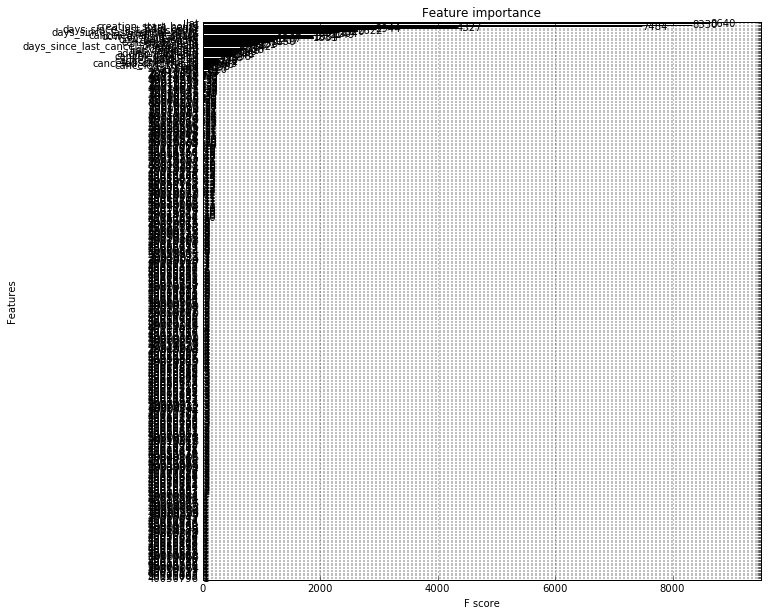

In [25]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

width = 20
height = 20
#plt.figure(figsize=(width, height))
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(bst, ax=ax)
